# This notebook shows how to fit a linear resonator in the reflection configuration.

In [1]:
from __future__ import division, absolute_import, print_function
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from resonator import background, reflection, see

Create data using the model plus gaussian noise. The model is the product of the reflection resonator model and a background model, which in this case assumes that the magnitude is independent of frequency and that the phase is described by an offset and an electrical delay, which adds a phase that is linearly dependent on frequency.

In [2]:
# Background model and parameters
background_model = background.MagnitudePhaseDelay()
magnitude = 0.01
phase = -np.pi / 2
delay = 70e-9

# Foreground model and parameters
foreground_model = reflection.LinearReflection()
resonance_frequency = 1e9
internal_loss = 1e-5  # Q_i = 100 000
coupling_loss = 5e-5  # Q_c = 20 000

# Create an array of measurement frequencies
linewidth = resonance_frequency * (internal_loss + coupling_loss)
frequency = np.linspace(resonance_frequency - 5 * linewidth, resonance_frequency + 5 * linewidth, 501)

# Create the data by evaluating the model functions with the given parameters
bg = background_model.func(frequency=frequency, frequency_reference=frequency.mean(), magnitude=magnitude, phase=phase, delay=delay)
fg = foreground_model.func(frequency=frequency, resonance_frequency=resonance_frequency, internal_loss=internal_loss, coupling_loss=coupling_loss)

# The ideal data is the product of the background and foreground, and we add some noise to this.
data = bg * fg + 0.05 * magnitude * (np.random.randn(frequency.size) + 1j * np.random.randn(frequency.size)) 

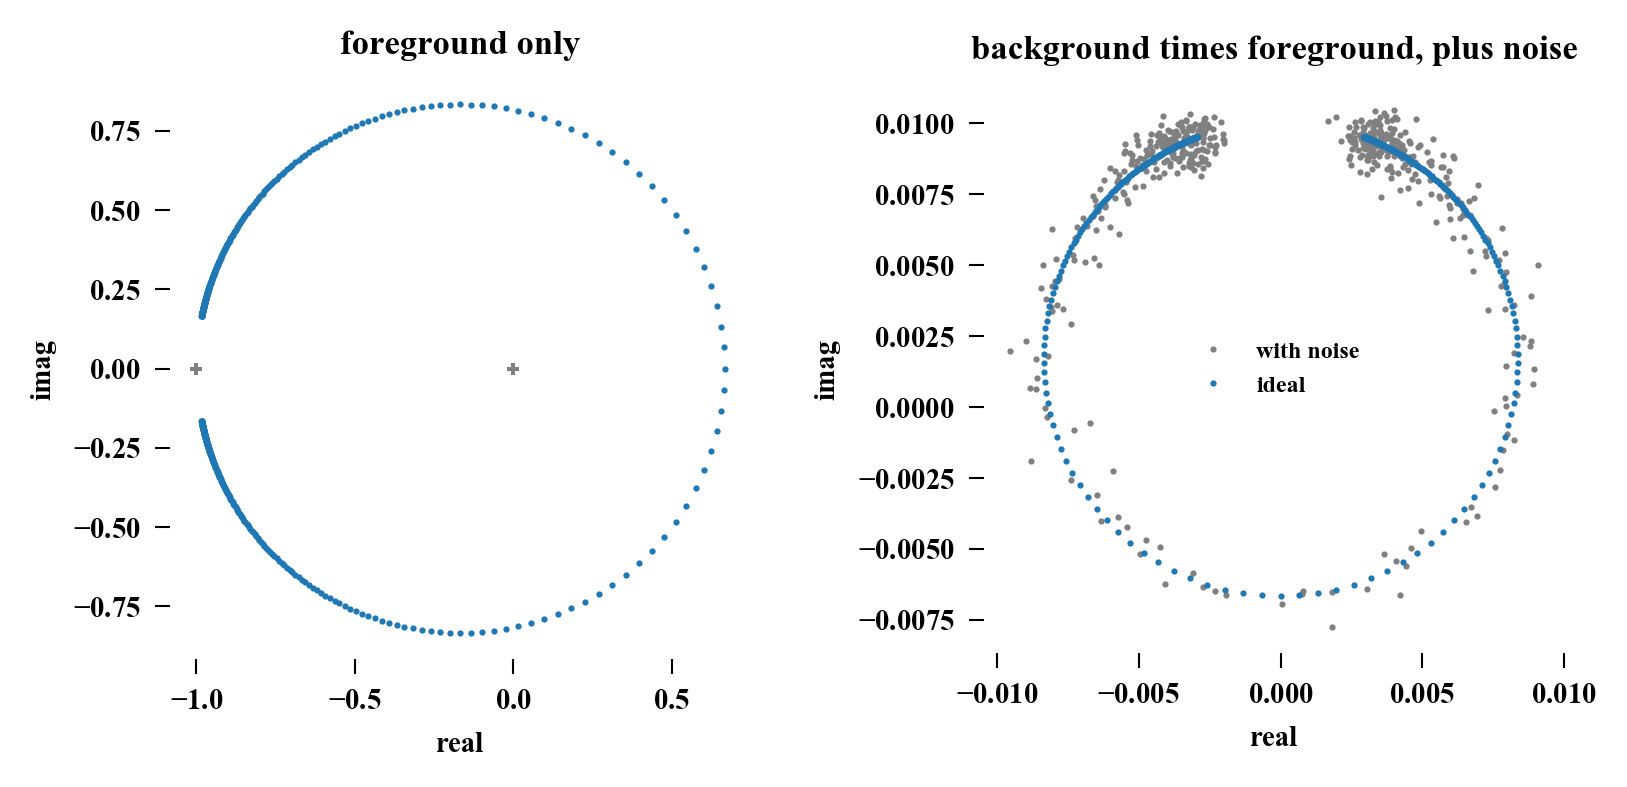

In [3]:
fig, (ax_fg, ax_bgfg) = plt.subplots(1, 2, figsize=(6, 3), dpi=300)

ax_fg.set_aspect('equal')
ax_fg.set_xlabel('real')
ax_fg.set_ylabel('imag')
ax_fg.plot(fg.real, fg.imag, '.')
ax_fg.plot([0, -1], [0, 0], marker='P', linestyle='none', color='gray')
ax_fg.set_title('foreground only')

ax_bgfg.set_aspect('equal')
ax_bgfg.set_xlabel('real')
ax_bgfg.set_ylabel('imag')
ax_bgfg.plot(data.real, data.imag, '.', color='gray', label='with noise')
ax_bgfg.plot((bg * fg).real, (bg * fg).imag, '.', label='ideal')
ax_bgfg.legend(fontsize='xx-small')
ax_bgfg.set_title('background times foreground, plus noise');

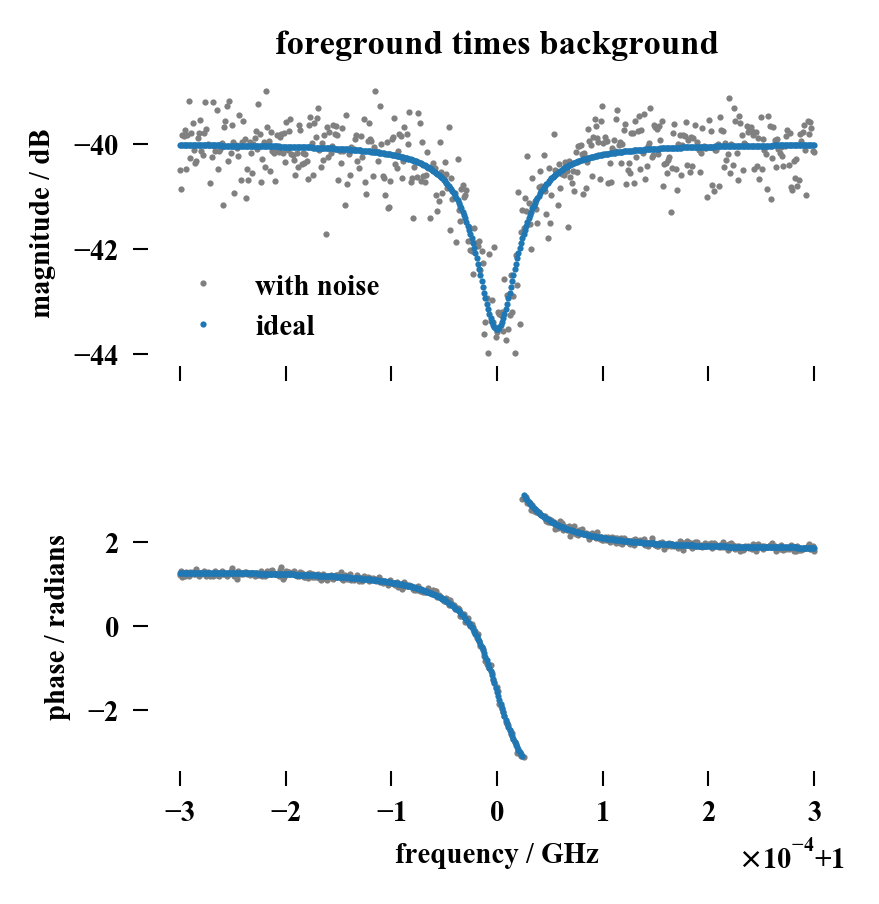

In [4]:
fig, (ax_mag, ax_phase) = plt.subplots(2, 1, sharex=True, figsize=(3, 3), dpi=300)

ax_mag.set_ylabel('magnitude / dB')
ax_mag.plot(1e-9 * frequency, 20 * np.log10(np.abs(data)), '.', color='gray', label='with noise')
ax_mag.plot(1e-9 * frequency, 20 * np.log10(np.abs(bg * fg)), '.', label='ideal')
ax_mag.set_title('foreground times background')
ax_mag.legend()

ax_phase.set_xlabel('frequency / GHz')
ax_phase.set_ylabel('phase / radians')
ax_phase.plot(1e-9 * frequency, np.angle(data), '.', color='gray', label='with noise')
ax_phase.plot(1e-9 * frequency, np.angle(bg * fg), '.', label='ideal');

## Fit the model to the data using a LinearReflectionFitter.

If no errors are given, the fitting assumes equal errors for each point and thus equal weights, so errors are not generally necessary unless they vary between points.

In [5]:
resonator = reflection.LinearReflectionFitter(frequency=frequency, data=data, background_model=background.MagnitudePhaseDelay())
print(resonator.result.fit_report())  # result is a lmfit.model.ModelResult object

[[Model]]
    (Model(magnitude_phase_delay) * Model(linear_reflection))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 1002
    # variables        = 6
    chi-square         = 2.4426e-04
    reduced chi-square = 2.4524e-07
    Akaike info crit   = -15245.4739
    Bayesian info crit = -15216.0154
[[Variables]]
    frequency_reference:  1e+09 (fixed)
    magnitude:            0.00998570 +/- 2.5970e-05 (0.26%) (init = 0.009495488)
    phase:               -1.57407818 +/- 0.00258467 (0.16%) (init = -1.548752)
    delay:                7.4978e-08 +/- 2.4530e-09 (3.27%) (init = 3.601734e-07)
    resonance_frequency:  1.0000e+09 +/- 165.187598 (0.00%) (init = 1.000002e+09)
    coupling_loss:        4.9445e-05 +/- 3.0354e-07 (0.61%) (init = 5.003082e-05)
    internal_loss:        9.7064e-06 +/- 3.2401e-07 (3.34%) (init = 8.769076e-06)
[[Correlations]] (unreported correlations are < 0.100)
    C(delay, coupling_loss)         = -0.552
   

## Plot the data

Use the `see.py` fitting module to plot the data, model, and resonance. To use these functions to make multiple plots in the same figure, we create the axes first and pass them to the plot functions.

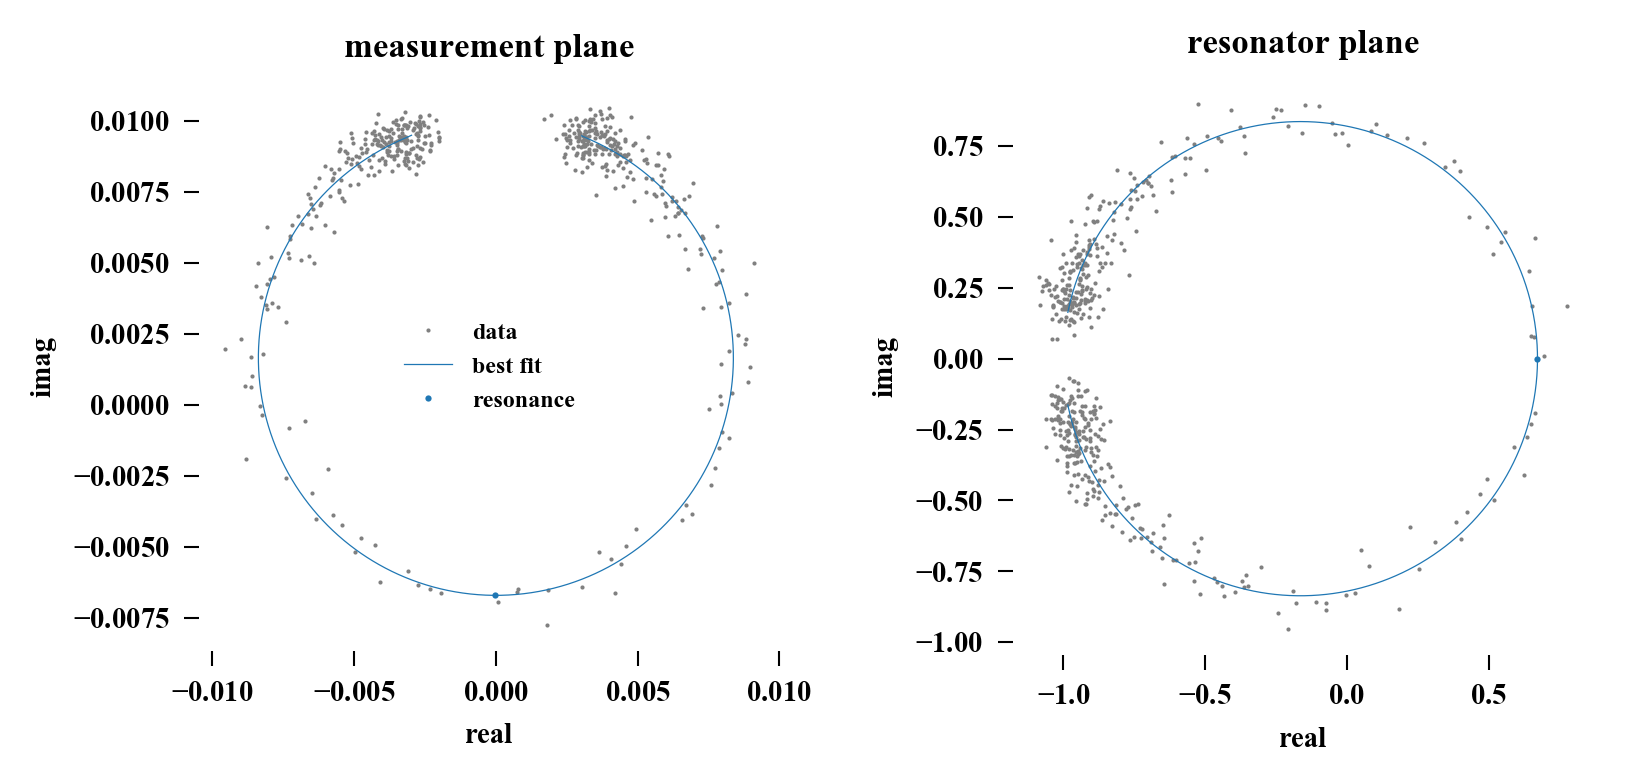

In [6]:
fig, (ax_raw, ax_norm) = plt.subplots(1, 2, figsize=(6, 3), dpi=300)  # Adjust these values for your plot settings
ax_raw.set_title('measurement plane')
ax_norm.set_title('resonator plane')
see.real_and_imaginary(resonator=resonator, axes=ax_raw, normalize=False)
see.real_and_imaginary(resonator=resonator, axes=ax_norm, normalize=True)
ax_raw.legend(fontsize='xx-small');

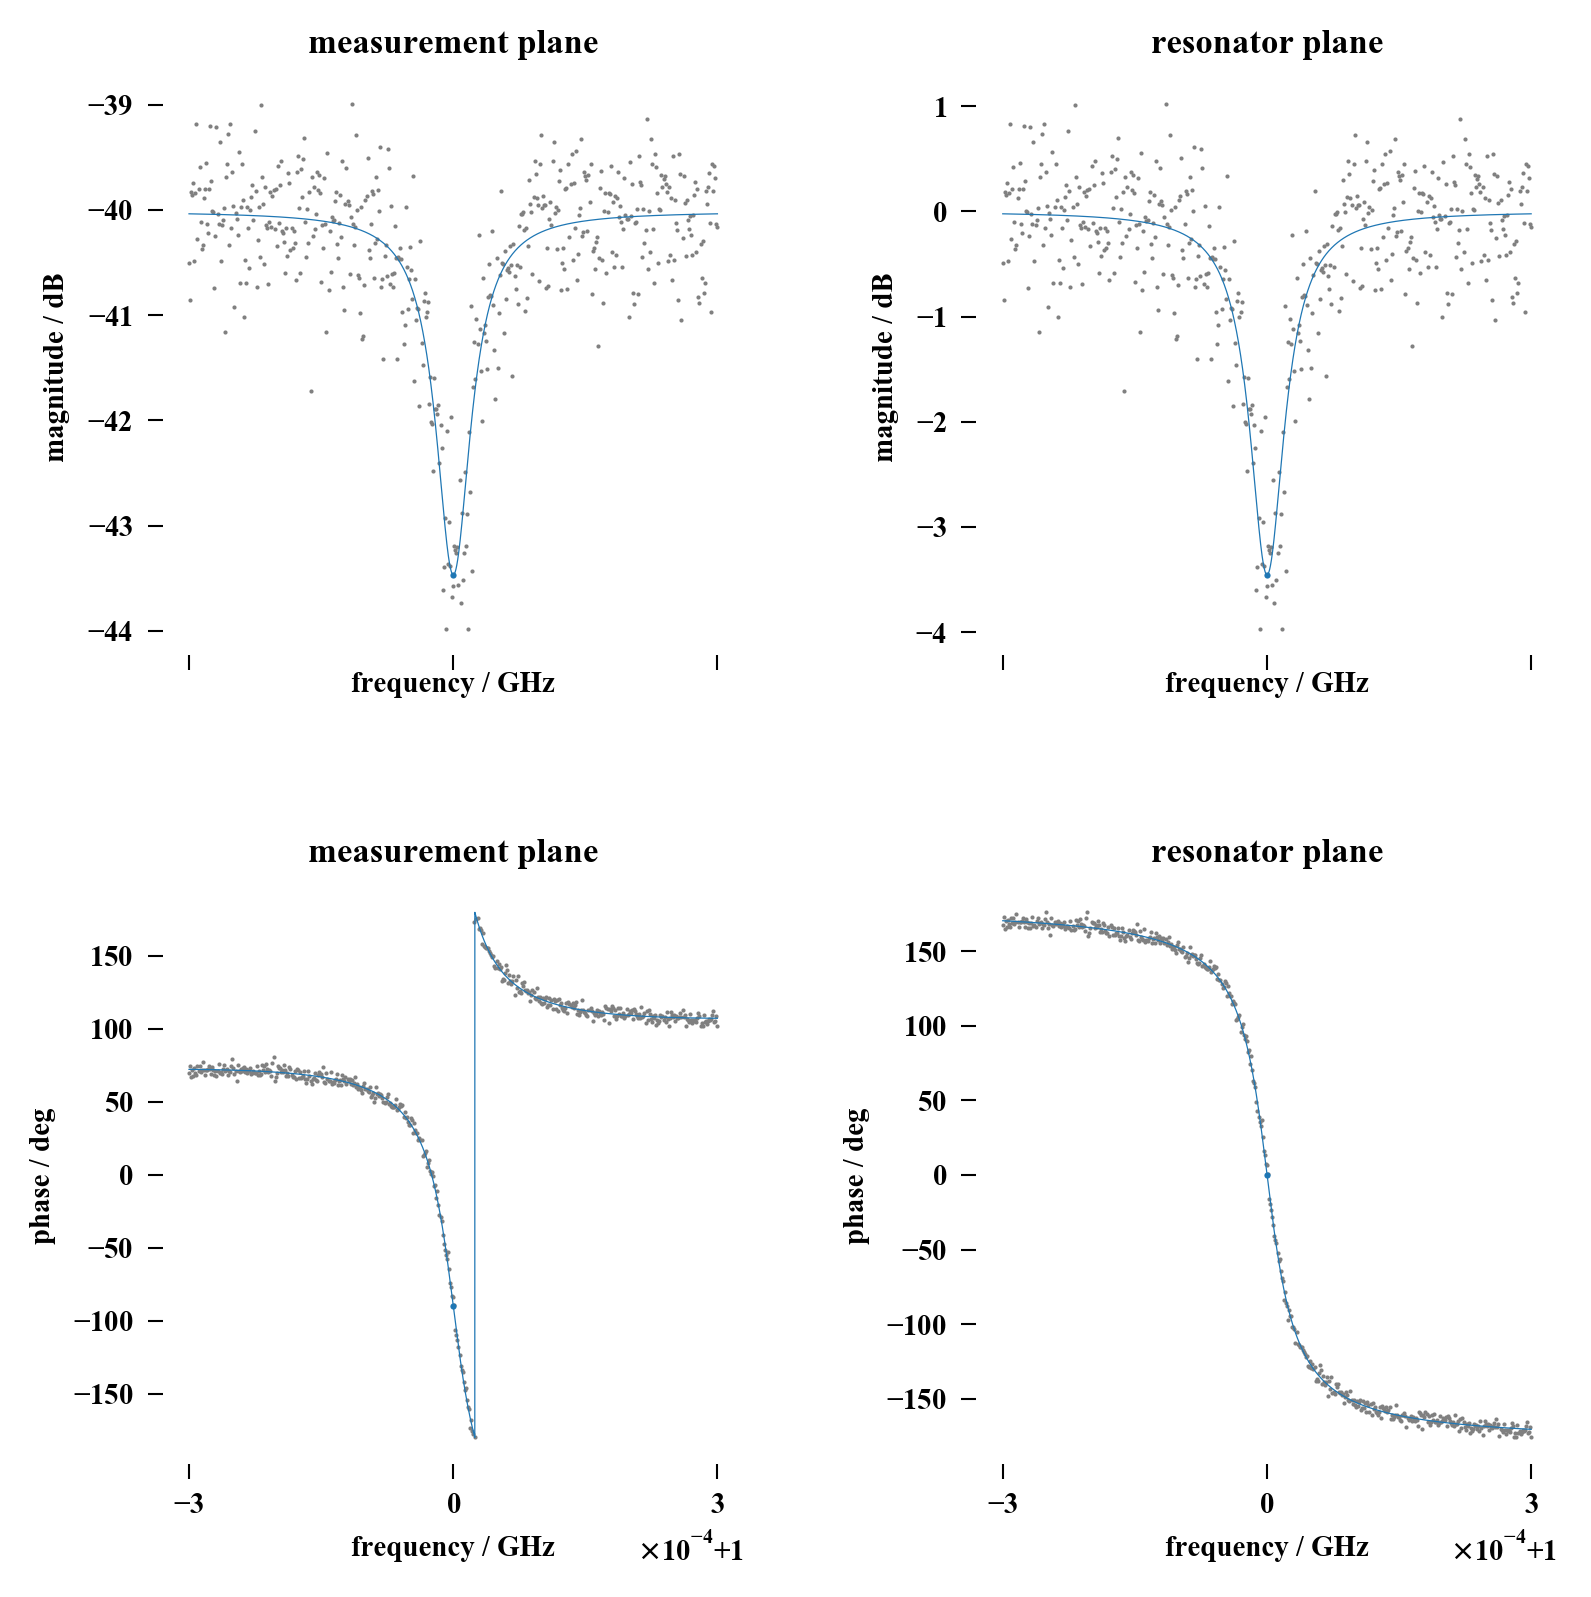

In [7]:
fig, axes = plt.subplots(2, 2, sharex='all', figsize=(6, 6), dpi=300)  # Adjust these values for your plot settings
ax_raw_mag, ax_norm_mag, ax_raw_phase, ax_norm_phase = axes.flatten()
ax_raw_mag.set_title('measurement plane')
ax_norm_mag.set_title('resonator plane')
ax_raw_phase.set_title('measurement plane')
ax_norm_phase.set_title('resonator plane')
see.magnitude_vs_frequency(resonator=resonator, axes=ax_raw_mag, normalize=False, frequency_scale=1e-9)
see.magnitude_vs_frequency(resonator=resonator, axes=ax_norm_mag, normalize=True, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_raw_phase, normalize=False, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_norm_phase, normalize=True, frequency_scale=1e-9);